In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
minute = True

In [4]:
data = None
if minute:
    data = pd.read_csv("BTCUSDT_1m.csv")
    data.drop(["Unnamed: 0", "Volume", "Close Unix"], axis=1, inplace=True)

else:
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [5]:
data

,Unix,Open,High,Low,Close,Quote Asset Volume,NTrades
0,1502942400000,4261.48,4261.48,4261.48,4261.48,7.564907e+03,3
1,1502942460000,4261.48,4261.48,4261.48,4261.48,0.000000e+00,0
2,1502942520000,4280.56,4280.56,4280.56,4280.56,1.117543e+03,2
3,1502942580000,4261.48,4261.48,4261.48,4261.48,5.117185e+01,3
4,1502942640000,4261.48,4261.48,4261.48,4261.48,5.999993e+02,1
...,...,...,...,...,...,...,...
3034363,1685522100000,27168.94,27171.58,27168.93,27171.57,3.026546e+05,416
3034364,1685522160000,27171.57,27177.57,27171.57,27177.56,4.025839e+05,432
3034365,1685522220000,27177.57,27177.94,27169.03,27169.03,7.875352e+05,600
3034366,1685522280000,27169.04,27170.51,27169.03,27170.50,1.436471e+05,232


In [6]:
agent_horizon = 7
crossover_horizon = 3

In [7]:
ma1, ma2 = 5, 10
k1, k2 = 10, 20
handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon)
handler.data.rename({'Label': 'Crossover'}, axis=1, inplace=True)
dummies = pd.get_dummies(handler.data['Crossover'], prefix='Crossover') * 1
handler.data.drop('Crossover', axis=1, inplace=True)
handler.data = pd.concat([handler.data, dummies], axis=1)
handler.data = triple_barrier_labelling(handler.data, upper_barrier=1.002, lower_barrier=0.998, time_limit=agent_horizon)
handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX, Indicators.OBV, Indicators.TICK_DENSITY])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.OBV, Indicators.PERC_RET,
                              Indicators.TICK_DENSITY])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'MA{ma1} Var'], predict_data[f'MA{ma2} Var'] = handler.data[f'MA{ma1} Var'], handler.data[f'MA{ma2} Var']
predict_data[dummies.columns] = handler.data[dummies.columns]
predict_data[f'MA{ma1} UP'], predict_data[f'MA{ma2} UP'] = (handler.data[f'MA{ma1}'] > handler.data[f'MA{ma2}']) * 1, (handler.data[f'MA{ma1}'] < handler.data[f'MA{ma2}']) * 1
predict_data.reset_index(drop=True, inplace=True)

Could not add indicator OBV
Error message 'Volume'
Ignoring indicator OBV. Reason: Not found in the list of indicators


C:\Users\Alexis\AppData\Local\Temp\ipykernel_22628\522258075.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_22628\522258075.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\Alexis\AppData\Local\Temp\ipykernel_22628\522258075.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [8]:
handler.data[dummies.columns]

,Crossover_-1,Crossover_0,Crossover_1
34,0,1,0
35,0,1,0
36,0,1,0
37,0,1,0
38,0,1,0
...,...,...,...
3034356,0,1,0
3034357,0,1,0
3034358,0,1,0
3034359,0,0,1


In [9]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,TICK_DENSITY Var,PERC_RET,Target,Kendall_10,Kendall_20,MA5 Var,MA10 Var,Crossover_-1,Crossover_0,Crossover_1,MA5 UP,MA10 UP
0,1502944440000,4.139614e-01,0.798672,2.062158,0.152935,-4.078915e-01,7.318456e-01,0.0,0.006710,0.0,0.483651,0.658470,0.001647,0.000711,0,1,0,1,0
1,1502944500000,2.138691e-02,0.402569,0.469760,0.129531,-5.438771e-02,3.336319e-02,0.0,0.000873,0.0,0.582025,0.677422,0.000953,0.000798,0,1,0,1,0
2,1502944560000,2.220446e-16,0.213479,0.138932,0.102704,2.220446e-16,2.220446e-16,0.0,0.000000,1.0,0.644061,0.689002,0.001201,0.000797,0,1,0,1,0
3,1502944620000,0.000000e+00,0.126436,0.013875,0.083678,-2.220446e-16,-2.220446e-16,0.0,0.000000,1.0,0.675149,0.712161,0.001199,0.000797,0,1,0,1,0
4,1502944680000,0.000000e+00,0.076544,-0.056144,0.069571,0.000000e+00,0.000000e+00,0.0,0.000000,1.0,0.677111,0.728396,0.001509,0.000796,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030649,1685521680000,-2.667242e-02,0.594462,0.052496,-0.034734,3.035747e-02,-2.106303e-02,0.0,-0.000092,0.0,-0.600000,-0.560854,-0.000037,-0.000145,0,1,0,0,1
3030650,1685521740000,-3.677915e-02,0.378677,0.043665,-0.020629,3.983792e-02,-2.904419e-02,0.0,-0.000122,0.0,-0.600000,-0.666676,-0.000070,-0.000128,0,1,0,0,1
3030651,1685521800000,-2.553688e-02,0.250816,0.013197,-0.010582,2.671334e-02,-2.090967e-02,0.0,-0.000081,0.0,-0.733333,-0.712404,-0.000117,-0.000058,0,1,0,0,1
3030652,1685521860000,2.313050e-01,-0.091153,-0.295652,-0.068549,-1.208791e-01,1.901846e-01,0.0,0.000508,0.0,-0.511111,-0.649079,-0.000002,-0.000017,0,0,1,0,1


In [10]:
predict_data['PERC_RET'].abs().describe()

count    3.030654e+06
mean     6.987257e-04
std      1.111638e-03
min      0.000000e+00
25%      1.420888e-04
50%      3.834761e-04
75%      8.334872e-04
max      7.497000e-02
Name: PERC_RET, dtype: float64

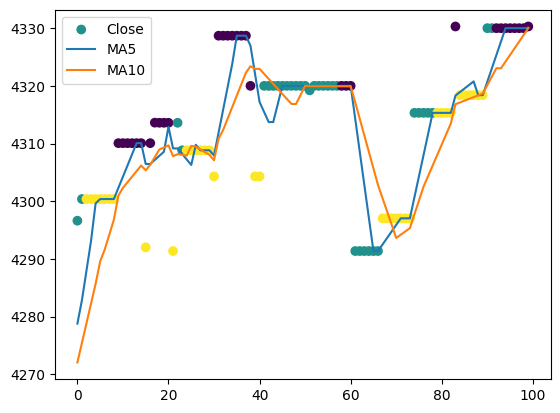

In [11]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'MA{ma1}'][0:100], label=f"MA{ma1}")
plt.plot(range(100), handler.data[f'MA{ma2}'][0:100], label=f"MA{ma2}")
plt.legend()
plt.show()

In [12]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,TICK_DENSITY Var,PERC_RET,Target,Kendall_10,Kendall_20,MA5 Var,MA10 Var,Crossover_-1,Crossover_0,Crossover_1,MA5 UP,MA10 UP
0,1502944440000,4.139614e-01,0.798672,2.062158,0.152935,-4.078915e-01,7.318456e-01,0.0,0.006710,0.0,0.483651,0.658470,0.001647,0.000711,0,1,0,1,0
1,1502944500000,2.138691e-02,0.402569,0.469760,0.129531,-5.438771e-02,3.336319e-02,0.0,0.000873,0.0,0.582025,0.677422,0.000953,0.000798,0,1,0,1,0
2,1502944560000,2.220446e-16,0.213479,0.138932,0.102704,2.220446e-16,2.220446e-16,0.0,0.000000,1.0,0.644061,0.689002,0.001201,0.000797,0,1,0,1,0
3,1502944620000,0.000000e+00,0.126436,0.013875,0.083678,-2.220446e-16,-2.220446e-16,0.0,0.000000,1.0,0.675149,0.712161,0.001199,0.000797,0,1,0,1,0
4,1502944680000,0.000000e+00,0.076544,-0.056144,0.069571,0.000000e+00,0.000000e+00,0.0,0.000000,1.0,0.677111,0.728396,0.001509,0.000796,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030649,1685521680000,-2.667242e-02,0.594462,0.052496,-0.034734,3.035747e-02,-2.106303e-02,0.0,-0.000092,0.0,-0.600000,-0.560854,-0.000037,-0.000145,0,1,0,0,1
3030650,1685521740000,-3.677915e-02,0.378677,0.043665,-0.020629,3.983792e-02,-2.904419e-02,0.0,-0.000122,0.0,-0.600000,-0.666676,-0.000070,-0.000128,0,1,0,0,1
3030651,1685521800000,-2.553688e-02,0.250816,0.013197,-0.010582,2.671334e-02,-2.090967e-02,0.0,-0.000081,0.0,-0.733333,-0.712404,-0.000117,-0.000058,0,1,0,0,1
3030652,1685521860000,2.313050e-01,-0.091153,-0.295652,-0.068549,-1.208791e-01,1.901846e-01,0.0,0.000508,0.0,-0.511111,-0.649079,-0.000002,-0.000017,0,0,1,0,1


In [13]:
seq_length = 15
dataset = TSDataset(predict_data, seq_length)

In [14]:
train_indices = range(0, round(0.7 * len(dataset)), int(seq_length))
val_indices = range(round(0.7 * len(dataset)), round(0.9 * len(dataset)), int(seq_length))
test_indices = range(round(0.9 * len(dataset)), len(dataset) - seq_length)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices) # Validation set will be training set for Meta Labelling
test_set = torch.utils.data.Subset(dataset, test_indices)

In [15]:
label_distribution = (predict_data.loc[train_set.indices, 'Target'].value_counts() / predict_data.loc[train_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[train_set.indices, 'Target'].value_counts())
label_distribution

Target
 0.0    65494
-1.0    38866
 1.0    37070
Name: count, dtype: int64

[0.27480732517853357, 0.46308421127059324, 0.26210846355087325]

In [16]:
class_weights = [1 / p for p in label_distribution]
print(class_weights)
# class_weights = [4, 1, 4]
weights = [class_weights[torch.argmax(label)] for _, label in train_set]
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_set), replacement=True)
# train_sampler = None

[3.63891318890547, 2.159434452010871, 3.8152144591313726]


In [17]:
input_size = dataset.size
hidden_size = 300
batch_size = 256
num_layers = 1
output_size = predict_data['Target'].unique().size
lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, output_size).to(device)

In [18]:
weights = torch.Tensor(label_distribution).to(device)
train_lstm(lstm_model, train_set, val_set, 30, 0.0001,
           batch_size, num_layers, hidden_size, device, train_sampler, class_weights=None, model_name=f'agent_{seq_length}_to_{agent_horizon}', save=True)

Epoch: 1/30 -- [65254/141430 (100.0%)]	Loss: 1.0886757992490936	Accuracy: 0.378	Time taken: 198.9375	Validation Loss: 1.0861790180206299 || Validation Accuracy: 0.362
Epoch: 2/30 -- [65254/141430 (100.0%)]	Loss: 1.063324705817169	Accuracy: 0.425	Time taken: 215.890625	Validation Loss: 1.087445616722107 || Validation Accuracy: 0.353
Epoch: 3/30 -- [65254/141430 (100.0%)]	Loss: 1.057862039284939	Accuracy: 0.431	Time taken: 214.40625	Validation Loss: 1.071086049079895 || Validation Accuracy: 0.394
Epoch: 4/30 -- [65254/141430 (100.0%)]	Loss: 1.0569310220628707	Accuracy: 0.432	Time taken: 216.546875	Validation Loss: 1.0821787118911743 || Validation Accuracy: 0.369
Epoch: 5/30 -- [65254/141430 (100.0%)]	Loss: 1.0548245753776315	Accuracy: 0.435	Time taken: 215.203125	Validation Loss: 1.093664526939392 || Validation Accuracy: 0.349
Epoch: 6/30 -- [65254/141430 (100.0%)]	Loss: 1.0530821848088103	Accuracy: 0.438	Time taken: 217.578125	Validation Loss: 1.0754051208496094 || Validation Accuracy: 

([1.0886757992490936,
  1.063324705817169,
  1.057862039284939,
  1.0569310220628707,
  1.0548245753776315,
  1.0530821848088103,
  1.052330633399715,
  1.0508911169890254,
  1.0506349890400228,
  1.0492392416241803,
  1.0487350031437106,
  1.0492449231432317,
  1.0475019287675027,
  1.0471268806060874,
  1.0459411614195564,
  1.0466230079450831,
  1.043547617052606,
  1.0438722077804277,
  1.0427011127497792,
  1.041565661620059,
  1.0411754827171726,
  1.03986485774004,
  1.038474617879602,
  1.0377667358727827,
  1.036873100786916,
  1.0359832447217558,
  1.0334493290451077,
  1.0316734989771577,
  1.0291776992313253,
  1.0252674711332614],
 [0.37805274694195007,
  0.42492399066676095,
  0.4311037262249876,
  0.43169058898394963,
  0.43516227108817085,
  0.43815314996818217,
  0.43983596125291663,
  0.44226118928091634,
  0.44199250512621086,
  0.44453793396026303,
  0.4462985222371491,
  0.4441066251856042,
  0.448681326451248,
  0.4492469773032596,
  0.4509227179523439,
  0.448596

In [19]:
eval_lstm(lstm_model, test_set, 64, num_layers, hidden_size, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 4.00 GiB total capacity; 3.50 GiB already allocated; 0 bytes free; 3.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF